# Fit Convergent Cross Mapping Model to Data Sets

In [210]:
import pandas as pd
import numpy as np
import skccm as ccm
import matplotlib.pyplot as plt
import seaborn as sns
from skccm.utilities import train_test_split
from teaspoon.parameter_selection.FNN_n import FNN_n

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [215]:
# from 2012-2020 9 years in total, 12 months for each year
merged_data = pd.read_csv('./data/merged_data.csv',index_col=0)
merged_data = merged_data.sort_values(by=['year','month'],ascending=[True, True])

## Part A: State-wise

In [216]:
state_list = list(set(merged_data['USstate'].to_list()))
print(len(state_list))

46


### Quick View

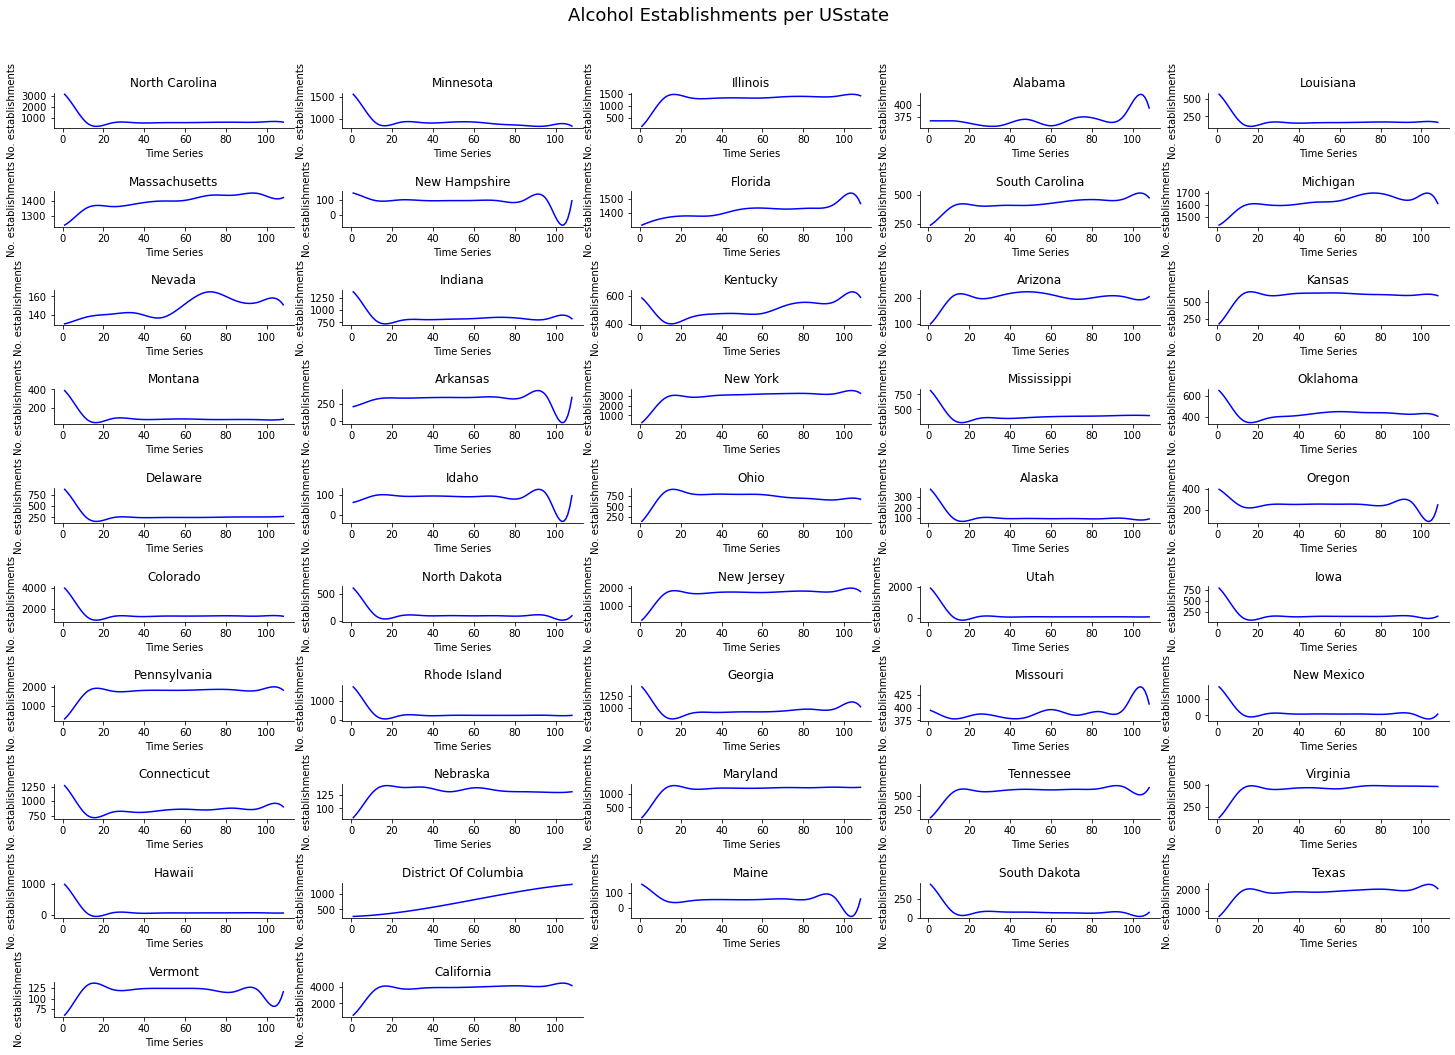

In [213]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Alcohol Establishments per USstate", fontsize=18, y=0.95)

for i in range(len(state_list)):
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['misogyny_proportion'] = data['nTweets_y'] / data['nTweets_x']
    data['crime_proportion'] = data['actual_rape_total'] / data['population']
    
    # 0. extract data
    x1_alcohol = data['Number of establishments (ESTAB)'].to_numpy()
    
    ax = plt.subplot(10, 5, i+1)
    ax.plot(np.arange(1,109), x1_alcohol, color='blue')
    ax.set_xlabel('Time Series')
    ax.set_ylabel('No. establishments')
    ax.set_title(curr_state)
    sns.despine()

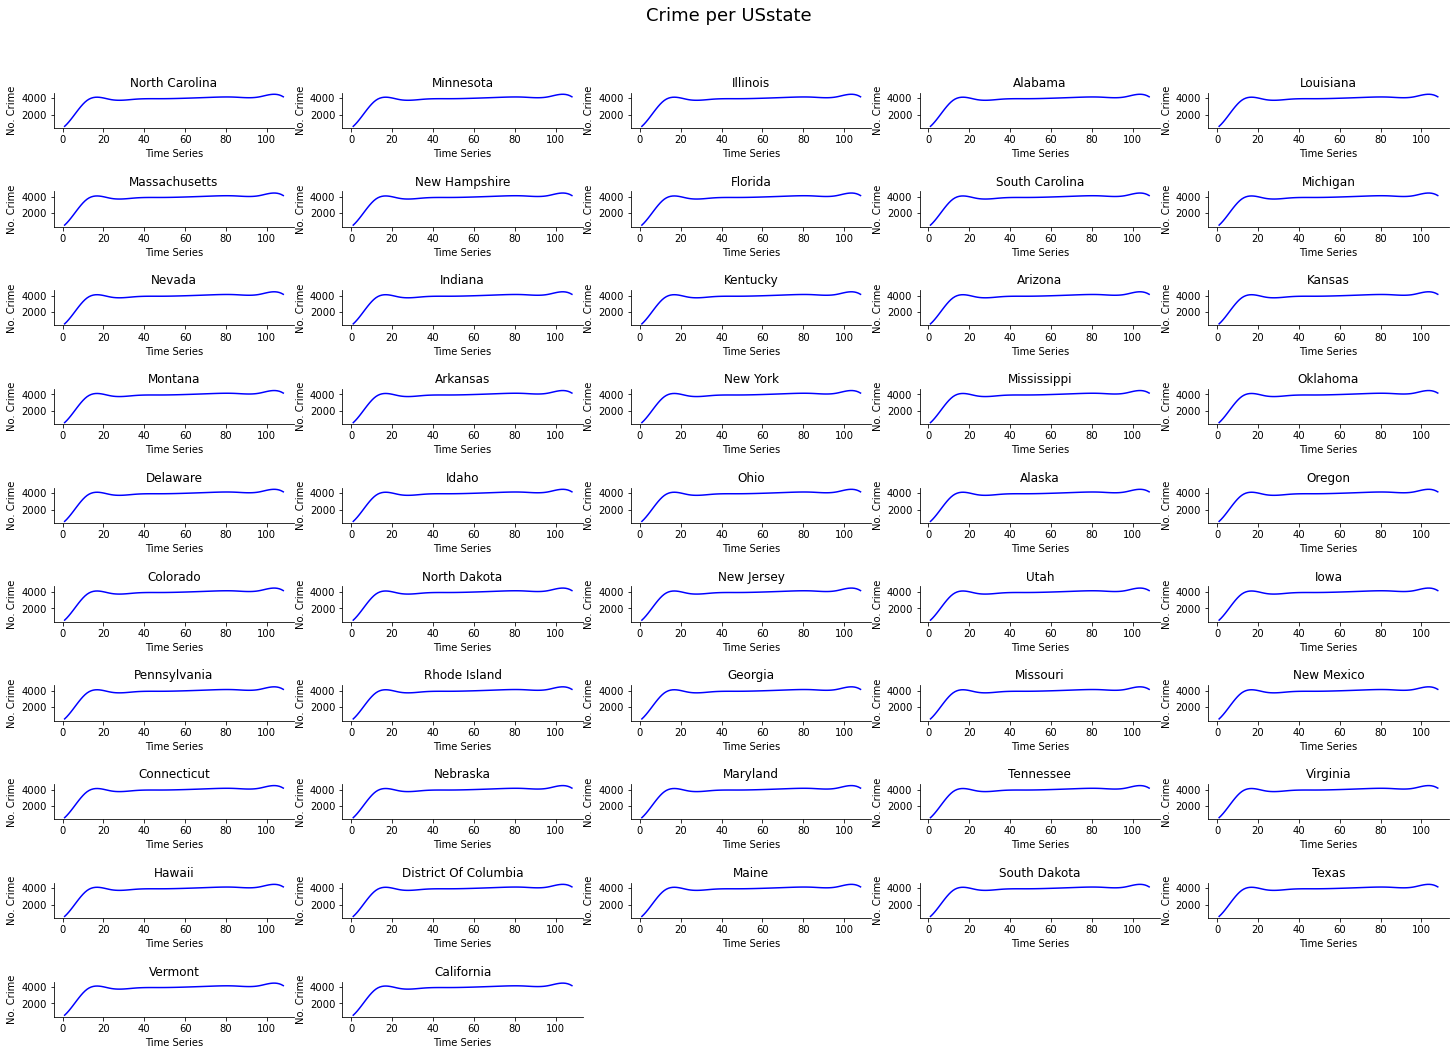

In [214]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Crime per USstate", fontsize=18, y=0.95)

for i in range(len(state_list)):
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['misogyny_proportion'] = data['nTweets_y'] / data['nTweets_x']
    data['crime_proportion'] = data['actual_rape_total'] / data['population']
    
    # 0. extract data
    x2_crime = data['crime_proportion'].to_numpy()
    
    ax = plt.subplot(10, 5, i+1)
    ax.plot(np.arange(1,109), x1_alcohol, color='blue')
    ax.set_xlabel('Time Series')
    ax.set_ylabel('No. Crime')
    ax.set_title(curr_state)
    sns.despine()

### Fit CCM

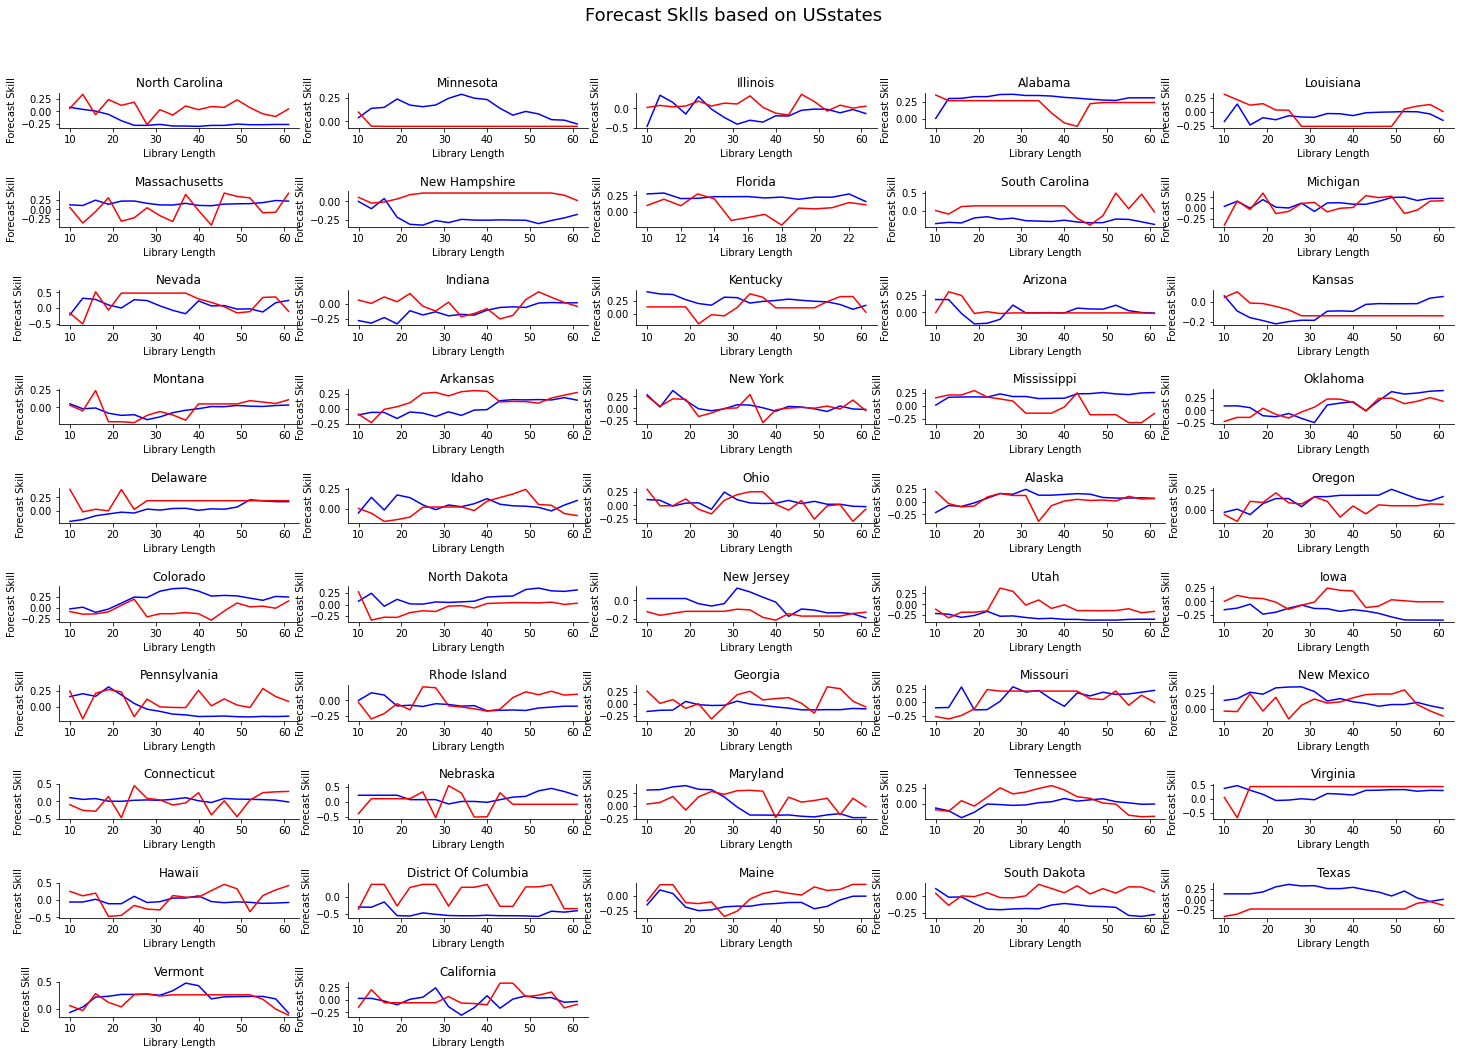

In [187]:
plt.figure(figsize=(25, 17))
plt.subplots_adjust(hspace=1.8)
plt.suptitle("Forecast Sklls based on USstates", fontsize=18, y=0.95)

for i in range(len(state_list)):
    
    data = merged_data[merged_data['USstate']==state_list[i]]
    curr_state = data['full'].iloc[0]
    data = data.groupby(['year','month']).sum()
    data['misogyny_proportion'] = data['nTweets_y'] / data['nTweets_x']
    data['crime_proportion'] = data['actual_rape_total'] / data['population']
    
    # 0. extract data
    x1_alcohol = data['Number of establishments (ESTAB)'].to_numpy()
    x2_crime = data['crime_proportion'].to_numpy()
    
    # 1. Calculate Mutual information
    e1 = ccm.Embed(x1_alcohol)
    e2 = ccm.Embed(x2_crime)

    mi1 = e1.mutual_information(10)
    mi2 = e2.mutual_information(10)
               
    min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
    min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
    min_index1 = max(min_index1, 1)
    min_index2 = max(min_index2, 1)
    lag = max(min_index1, min_index2)
    
    # 2. Embed the time series
    perc_FNN, embed = FNN_n(x2_crime, lag, plotting = False)
    X1 = e1.embed_vectors_1d(lag,embed)
    X2 = e2.embed_vectors_1d(lag,embed)
    
    # 3. Forecast skill as a function of library length
    # split the embedded time series
    x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

    CCM = ccm.CCM() # initiate the class

    # library lengths to test
    len_tr = len(x1tr)
    lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')
    
    # test causation
    CCM.fit(x1tr,x2tr)
    x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)
    
    sc1,sc2 = CCM.score()
    # plot
    ax = plt.subplot(10, 5, i+1)
    ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # alcohol predict crime
    ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # crime predict alcohol
    ax.set_xlabel('Library Length')
    ax.set_ylabel('Forecast Skill')
    ax.set_title(curr_state)
    sns.despine()

## Part B: Country-wise

In [191]:
merged_data2 = merged_data.groupby(['year','month']).sum()
merged_data2['crime_proportion'] = merged_data2['actual_rape_total'] / merged_data2['population']
merged_data2 = merged_data2.drop(columns=['nTweets_x', 'nTweets_y'])
merged_data2

Number of establishments (ESTAB)  population  actual_rape_total  \
year month                                                                    
2012 1                          34677.072070   304482719               6010   
     2                          34420.617912   304482719               5516   
     3                          34127.260968   304482719               6430   
     4                          33806.825286   304482719               5980   
     5                          33469.134914   304482719               6251   
...                                      ...         ...                ...   
2020 8                          35343.331661   319442671               9574   
     9                          35321.347613   319442671               9099   
     10                         35260.531362   319442671               8618   
     11                         35154.982194   319442671               7700   
     12                         34998.799397   319442671              14360   

            crime_proportion  
year month                    
2012 1              0.000020  
     2              0.000018  
     3              0.000021  
     4              0.000020  
     5              0.000021  
...                      ...  
2020 8              0.000030  
     9              0.000028  
     10             0.000027  
     11             0.000024  
     12             0.000045  

[108 rows x 4 columns]

## 0. Extract data

In [192]:
x1_alcohol = merged_data2['Number of establishments (ESTAB)'].to_numpy()
x2_crime = merged_data2['crime_proportion'].to_numpy()

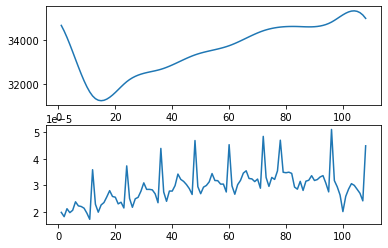

In [193]:
fig,ax = plt.subplots(nrows=2,sharex=False,sharey=False)
ax[0].plot(np.arange(1,109),x1_alcohol)
ax[1].plot(np.arange(1,109),x2_crime)

In [194]:
corr = merged_data2.corr() #reference correlation
corr

,Number of establishments (ESTAB),population,actual_rape_total,crime_proportion
Number of establishments (ESTAB),1.000000,0.843217,0.409460,0.364275
population,0.843217,1.000000,0.554608,0.507101
actual_rape_total,0.409460,0.554608,1.000000,0.998321
crime_proportion,0.364275,0.507101,0.998321,1.000000


# Alcohol vs Crime

## 1. Calculate Mutual information

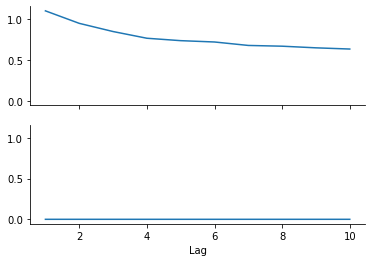

In [195]:
e1 = ccm.Embed(x1_alcohol)
e2 = ccm.Embed(x2_crime)

mi1 = e1.mutual_information(10)
mi2 = e2.mutual_information(10)

fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True)
ax[0].plot(np.arange(1,11),mi1)
ax[1].plot(np.arange(1,11),mi2)
ax[1].set_xlabel('Lag')
sns.despine()

In [196]:
min_index1 = min(range(len(mi1)), key=mi1.__getitem__)
min_index2 = min(range(len(mi2)), key=mi2.__getitem__)
min_index1 = max(min_index1, 1)
min_index2 = max(min_index2, 1)
lag = max(min_index1, min_index2)
print(lag)

9


## 2. Embed the time series

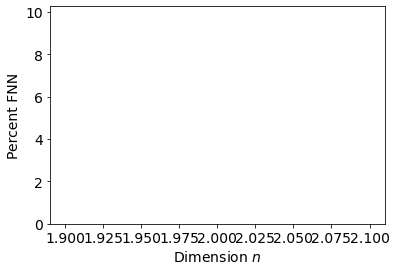

FNN embedding Dimension:  2


In [197]:
perc_FNN, embed = FNN_n(x2_crime, lag, plotting = True)
print('FNN embedding Dimension: ',embed)
X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)

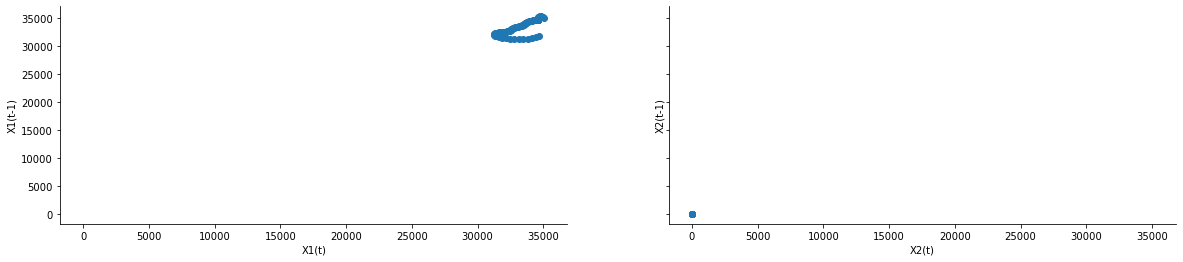

In [198]:
fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,figsize=(20,4)) 
ax[0].scatter(X1[:,0],X1[:,1])
ax[1].scatter(X2[:,0],X2[:,1])
ax[0].set_xlabel('X1(t)')
ax[0].set_ylabel('X1(t-1)')
ax[1].set_xlabel('X2(t)')
ax[1].set_ylabel('X2(t-1)')
sns.despine()

## 3. Forecast skill as a function of library length

In [203]:
#split the embedded time series
x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.75)

CCM = ccm.CCM() #initiate the class

#library lengths to test
len_tr = len(x1tr)
lib_lens = np.arange(10, len_tr, len_tr/20, dtype='int')

#test causation
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)

sc1,sc2 = CCM.score()

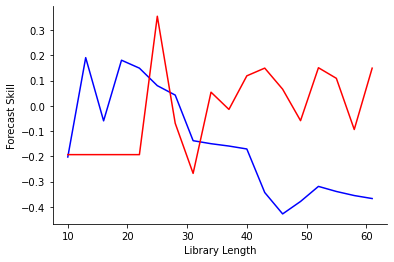

In [204]:
fig,ax = plt.subplots()
ax.plot(lib_lens,sc1,label='X1 xmap X2', color='blue') # alcohol predict crime
ax.plot(lib_lens,sc2, label='X2 xmap X1', color='red') # crime predict alcohol
ax.set_xlabel('Library Length')
ax.set_ylabel('Forecast Skill')
sns.despine()